In [1]:
import time
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

# conditional random fields
import ace_sklearn_crfsuite
from ace_sklearn_crfsuite import metrics

# self-made
import src.analysis as analysis
import src.anomaly_model as anomaly_model
import src.utils as utils
import src.sensor_model as sensor_model

working_path = Path().resolve()
layout_database_path = working_path / "layout_data"

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Returns
    -------
    feature : numpy.ndarray
        (number of time, dimension of feature).
        feature[t] = feature vector of the t-th time.
        feature.shape[0] == mat.shape[0].
        Let w be a (window_len - 1)/2.
        feature.shape[i] is a vector made from mat[i-w/2:i+w/2+1] for any w/2 <= i <mat.shape[0]-w/2
        feature.shape[i] is a vector made from mat[0:i+w/2+1] for any i < w/2.
        feature.shape[i] is a vector made from mat[i-w/2:mat.shape[0]] for any i >= mat.shape[0]-w/2.
        sensor_num_dic saves the realtion between index of sensors and index of features.
    """
    feature = np.zeros((mat.shape[0], mat.shape[1]), dtype = np.int32)
    for i, item in enumerate(gen_fall_feature_sliding(mat, time_step, window_len, nrt_type)):
        feature[i] = item
    return feature

def gen_fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Generator.
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Yields
    ------
    feature : numpy.ndarray
        (dimension of feature, ).
    """

    def edge_detection(window_data):
        """
        Parameters
        ----------
        window_data : numpy.ndarray
            Non response time. The shape is (window_len, num. of sensors).

        Returns
        -------
        (left_edge_height, right_edge_height) : tuple of int
            left_edge_height is a maximum height of the edge in the left part of the window.
        """
        # Flatten the window by calculating max value among all sensors
        window_data = np.max(window_data, axis = 1)
        # convolution for edge detection
        _filter = np.array([-1, 1])
        edge = np.convolve(window_data, _filter, 'valid')
        half_window_len = int((len(window_data) - 1) / 2)
        left_edge_height = np.max(edge[:half_window_len])
        right_edge_height = np.max(edge[half_window_len:])
        return (left_edge_height, right_edge_height)
    
    def summarize_window(window_data):
        if nrt_type == "sum":
            return np.count_nonzero(window_data, axis=0)
        elif nrt_type == "max":
            return np.max(window_data, axis = 0)
        elif nrt_type == "instantaneous":
            center = int((window_data.shape[0] - 1) / 2)
            return window_data[center]

    # Initialize the output array
    sensor_num = mat.shape[1]
    last_fired_time = np.full((sensor_num,), -1)
    last_fired_sensors = np.zeros(sensor_num, dtype = bool)
    
    w = int((window_len - 1)/2)
    window_data = np.zeros((window_len, sensor_num))

    for i in range(w):
        sd = mat[i]
        if np.any(sd):
            for s in range(sensor_num):
                if not last_fired_sensors[s] and sd[s]:
                    last_fired_time[s] = i
                if last_fired_sensors[s] and not sd[s]:
                    last_fired_time[s] = -1
            last_fired_sensors = sd

        instantaneous_nrt = np.empty(sensor_num)
        for s in range(sensor_num):
            instantaneous_nrt[s] = ((i - last_fired_time[s] + 1) if last_fired_time[s] != -1 else 0)
        window_data[i+w+1, :] = instantaneous_nrt

    # [0, 0, 0, a, b] for example of w = 2.

    for i in range(w, mat.shape[0]):
        utils.print_progress_bar(mat.shape[0] - 1, i, "Extract fall features.", step = 1000)
        # center = i - w  # index of window center
        sd = mat[i]
        if np.any(sd):
            for s in range(sensor_num):
                if not last_fired_sensors[s] and sd[s]:
                    last_fired_time[s] = i
                if last_fired_sensors[s] and not sd[s]:
                    last_fired_time[s] = -1
            last_fired_sensors = sd

        instantaneous_nrt = np.empty(sensor_num)
        for s in range(sensor_num):
            instantaneous_nrt[s] = ((i - last_fired_time[s] + 1) if last_fired_time[s] != -1 else 0)

        # shift window
        # For example of w = 2;
        # from [a, b, c, d, e] to [b, c, d, e, f]
        window_data = np.roll(window_data, shift=-1, axis=0)
        window_data[-1, :] = instantaneous_nrt

        # Calculate elapsed time of the sliding window
        yield summarize_window(window_data) * time_step

    for center in range(mat.shape[0]-w, mat.shape[0]):
         # shift window
        window_data = np.roll(window_data, shift=-1, axis=0)
        window_data[-1, :] = np.zeros(sensor_num)

        # Calculate elapsed time of the sliding window
        yield summarize_window(window_data) * time_step

def extract_data_with_fall_feature_sliding(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    if data_range not in ["full", "around_anomalies"]:
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_1")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']):  
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]
    
    # extract features of non response time
    if data_range == "full":
        X = fall_feature_sliding(SD, time_step=time_step, window_len=window_len, nrt_type=nrt_type)
        return X, AL, motion_sensor_indexes
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        X = np.empty((0, len(motion_sensor_indexes)))
        y = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            feature = fall_feature_sliding(SD[start:end], time_step=time_step, window_len=window_len, nrt_type=nrt_type)
            X = np.vstack((X, feature))
            for i in range(start, end):
                y.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return X, np.array(y), motion_sensor_indexes
    
    
def online_detection_test(classifier, path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """
    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    # extract features of non response time
    if data_range == "full":
        y_pred = np.zeros(SD.shape[0], dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            y_pred[i] = classifier.predict(item.reshape(1, -1))
        return AL, y_pred
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier.predict(item.reshape(1, -1)))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier.predict(item.reshape(1, -1))
        return AL[start:end], y_pred


def online_detection_rule(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """


    def classifier_rule(vec, valid_range):
        for i, v in enumerate(vec):
            if (i in valid_range) and v >= 20:
                return True
        return False    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    valid_range = set(range(0, 23)) | {34, 35} 

    # extract features of non response time
    if data_range == "full":
        y_pred = np.zeros(SD.shape[0], dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL, y_pred
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier_rule(item, valid_range))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL[start:end], y_pred

data_type = "raw"
time_step = 1
window_len = 121
# half_len = 5000
half_len = 30000
nrt_type = "instantaneous"

# training data
# train_path = layout_database_path / "test_layout" / "test_data_3"
# X_train, y_train, motion_sensor_indexes  = extract_data_with_fall_feature_sliding(train_path, 
#         data_type = data_type, time_step = time_step, window_len = window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len)

train_path = layout_database_path / "test_layout" / "fall_test_3"
X_train, y_train, motion_sensor_indexes  = extract_data_with_fall_feature_sliding(train_path, 
        data_type = data_type, time_step = time_step, window_len = window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
print("Training data is ready!")

# decision tree
decision_tree = DecisionTreeClassifier(min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
print("Classifier is ready!")

# test data
test_path = layout_database_path / "test_layout" / "test_data_6"

y_test_dt, y_pred_dt = online_detection_test(decision_tree, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt, y_pred_dt))
print("Classification report")
print(classification_report(y_test_dt, y_pred_dt))

y_test_rule_longule, y_pred_rule_longule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_longule, y_pred_rule_longule))
print("Classification report")
print(classification_report(y_test_rule_longule, y_pred_rule_longule))

Extract fall features. 2591999 / 2591999. Completed!
Training data is ready!
Classifier is ready!
Extract fall features. 60033 / 60033. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60025 / 60025. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60042 / 60042. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60031 / 60031. Completed!
Extract fall features. 60033 / 60033. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60019 / 60019. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60015 / 60015. Completed!
Extract fall features. 60033 / 60033. Completed!
Extract fall features. 60033 / 60033. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall feature

[Text(0.4732142857142857, 0.9, 'x[18] <= 3.5\ngini = 0.005\nsamples = 2592000\nvalue = [2585862, 6138]'),
 Text(0.23214285714285715, 0.7, 'x[8] <= 3.5\ngini = 0.004\nsamples = 2590936\nvalue = [2585813, 5123]'),
 Text(0.14285714285714285, 0.5, 'x[4] <= 3.5\ngini = 0.003\nsamples = 2590057\nvalue = [2585796, 4261]'),
 Text(0.07142857142857142, 0.3, 'x[9] <= 3.5\ngini = 0.003\nsamples = 2589184\nvalue = [2585695, 3489]'),
 Text(0.03571428571428571, 0.1, '\n  (...)  \n'),
 Text(0.10714285714285714, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.3, 'x[25] <= 1.5\ngini = 0.205\nsamples = 873\nvalue = [101, 772]'),
 Text(0.17857142857142858, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.32142857142857145, 0.5, 'x[8] <= 26.5\ngini = 0.038\nsamples = 879\nvalue = [17, 862]'),
 Text(0.2857142857142857, 0.3, 'gini = 0.0\nsamples = 707\nvalue = [0, 707]'),
 Text(0.35714285714285715, 0.3, 'x[5] <= 13.5\ngini = 0.178\nsamples = 172\nvalue = [17, 155]'),
 Text(0.321428571428

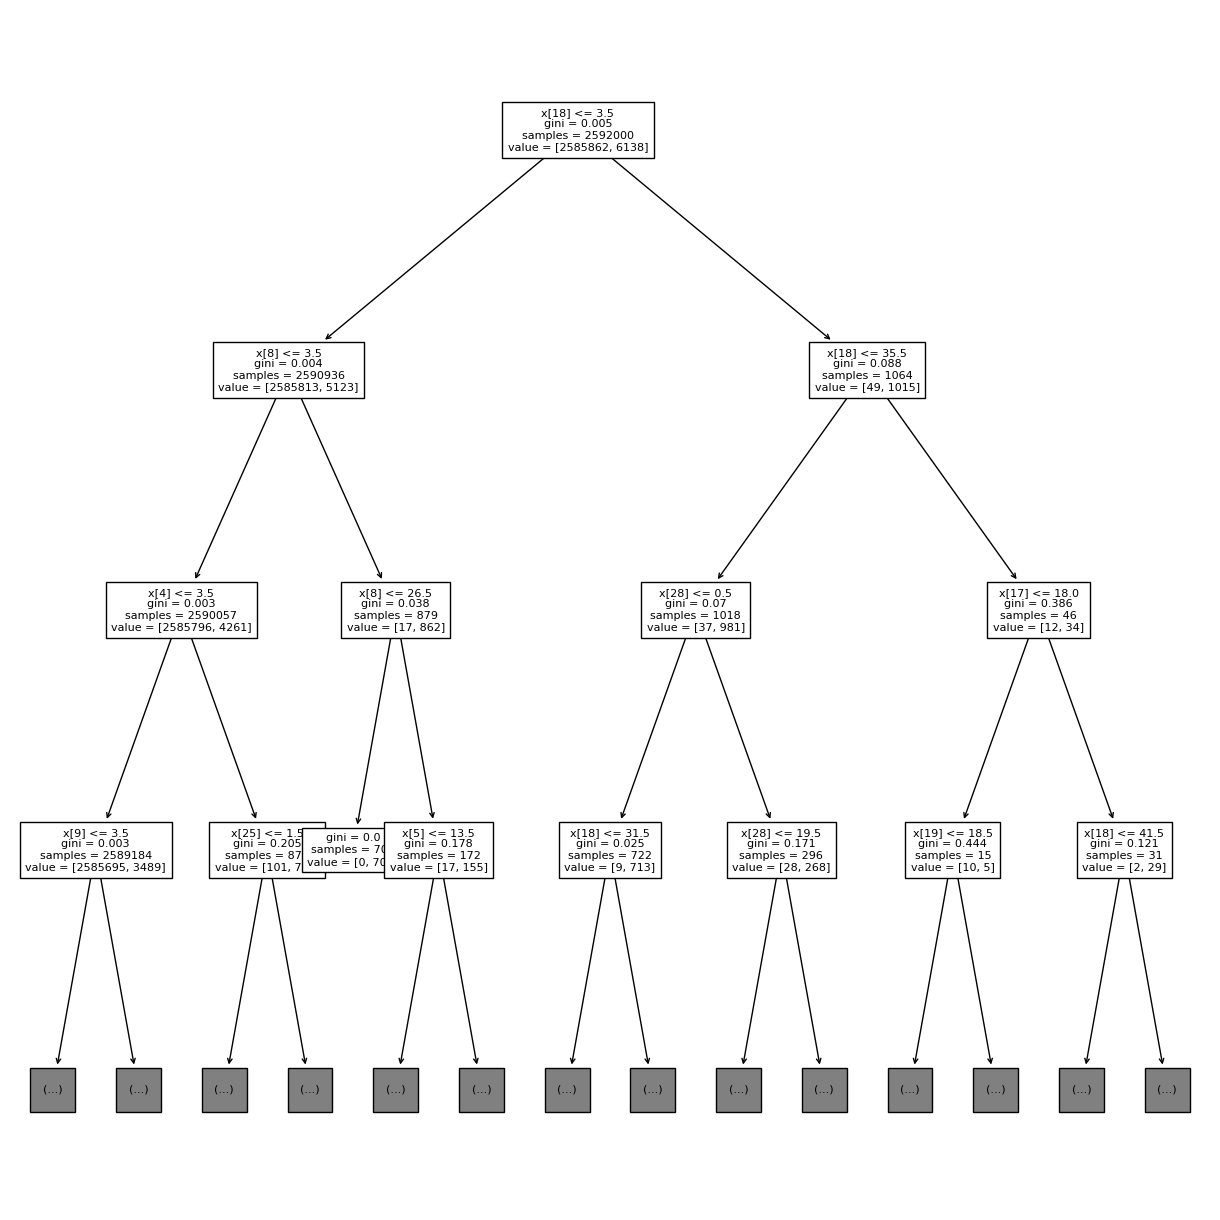

In [14]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12), tight_layout=dict(pad=0))
tree.plot_tree(decision_tree, ax=ax, max_depth=3, fontsize=8)
# plt.savefig(train_path / "experiment" / 'decision_tree_graph', dpi=200)

In [4]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
test_path = layout_database_path / "test_layout" / "test_data_6"
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)


print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))

y_test_dt_long, y_pred_dt_long = online_detection_test(decision_tree, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)

print("Test error DT------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt_long, y_pred_dt_long))
print("Classification report")
print(classification_report(y_test_dt_long, y_pred_dt_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error Rule------------------------
Confusion matrix:
[[7772272    3710]
 [     18       0]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775982
        True       0.00      0.00      0.00        18

    accuracy                           1.00   7776000
   macro avg       0.50      0.50      0.50   7776000
weighted avg       1.00      1.00      1.00   7776000

Extract fall features. 7775999 / 7775999. Completed!
Test error DT------------------------
Confusion matrix:
[[7769613    6369]
 [      1      17]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775982
        True       0.00      0.94      0.01        18

    accuracy                           1.00   7776000
   macro avg       0.50      0.97      0.50   7776000
weighted avg       1.00      1.00      1.00   7776000



len(consecutive_length): 1158
less than 5 [sec.]: 79


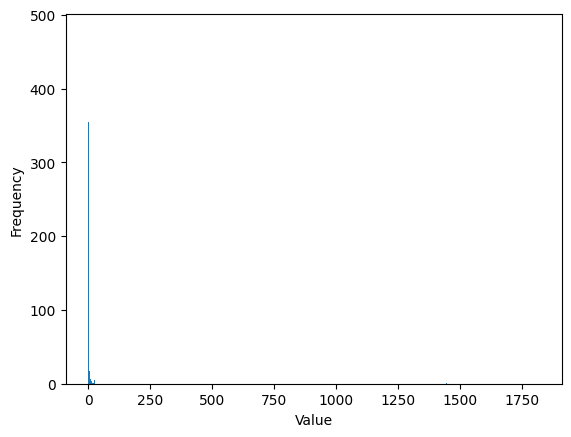

In [14]:
import matplotlib.pyplot as plt

true_regions = analysis.find_true_regions_in_ndarray(y_pred_dt_long)
consecutive_length = [r[1] - r[0] for r in true_regions]
print(f"len(consecutive_length): {len(consecutive_length)}")
seconds = 5
less_than_num = 0
for x in consecutive_length:
    if x > seconds:
        less_than_num += 1
print(f"less than {seconds} [sec.]: {less_than_num}")

sorted_one = sorted(consecutive_length)
plt.hist(sorted_one, bins=range(min(sorted_one), max(sorted_one) + 2), align='left', rwidth=0.8)

# X軸に表示する値の設定
# plt.xticks(range(min(new), max(new) + 1))

# タイトルと軸ラベルの追加
plt.xlabel('Value')
plt.ylabel('Frequency')

# ヒストグラムの表示
plt.show()

In [15]:
# AL = utils.pickle_load(test_path / "experiment", f"AL_mat_raw_1")
# SD = utils.pickle_load(test_path / "experiment", f"SD_mat_raw_1")
# target_AL = AL[target_r[0]:target_r[1], :]
# target_SD = SD[target_r[0]:target_r[1], :]
# print(np.sum(target_AL))
# print(np.sum(target_SD))

true_regions = analysis.find_true_regions_in_ndarray(y_pred_dt_long)
for r_ind, r in enumerate(true_regions):
    if r[1] - r[0] > 1000:
        print("exist!")
        break
target_r = (r[0] + start, r[1] + start)
print(target_r)
print(timedelta(seconds = int(target_r[0])))
print(timedelta(seconds = int(target_r[1])))

exist!
(275263454, 275265272)
3185 days, 22:04:14
3185 days, 22:34:32


In [36]:
AL = utils.pickle_load(test_path / "experiment", f"AL_mat_raw_1")
SD = utils.pickle_load(test_path / "experiment", f"SD_mat_raw_1")
target_AL = AL[target_r[0]:target_r[1], :]
target_SD = SD[target_r[0]:target_r[1], :]
print(np.sum(target_AL))
print(np.sum(target_SD))

0
0


In [35]:
for i in range(40):
    temp = SD[target_r[0]-i]
    if np.any(temp):
        print(i)
        print(np.where(temp)[0])


2
[23 34]
3
[ 3 34]
4
[3 4]
5
[3 4]
6
[4 5]
7
[5 6]
8
[5 6]
9
[6 9]
10
[ 9 10]
11
[10]
12
[10 11 18]
13
[18 19]
14
[18 19]
15
[19 20]
16
[20 30]
20
[30]
21
[30]
22
[30]
39
[30]


In [23]:
sensors = utils.pickle_load(test_path / "experiment", f"SD_model")
SD = utils.pickle_load(test_path / "experiment", f"SD_mat_raw_1")
utils.save_binary_sensor_data(test_path, sensors, sorted_sensor_data, filename="temp_temp")

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  :	:
  (0, 58)	1
  (0, 59)	1
  (0, 60)	1
  (0, 61)	1
  (0, 62)	1
  (0, 63)	1
  (0, 64)	1
  (0, 65)	1
  (0, 66)	1
  (0, 67)	1
  (0, 68)	1
  (0, 69)	1
  (0, 70)	1
  (0, 71)	1
  (0, 72)	1
  (0, 73)	1
  (0, 74)	1
  (0, 75)	1
  (0, 76)	1
  (0, 77)	1
  (0, 78)	1
  (0, 79)	1
  (0, 80)	1
  (0, 81)	1
  (0, 82)	1


In [7]:
interval = 5

compressed_y_test = np.array([all(y_test_rule_long[i:i+interval]) for i in range(0, len(y_test_rule_long), interval)])
compressed_y_pred = np.array([all(y_pred_rule_long[i:i+interval]) for i in range(0, len(y_pred_rule_long), interval)])

print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(compressed_y_test, compressed_y_pred))
print("Classification report")
print(classification_report(compressed_y_test, compressed_y_pred))

compressed_y_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
compressed_y_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])

print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(compressed_y_test, compressed_y_pred))
print("Classification report")
print(classification_report(compressed_y_test, compressed_y_pred))

Test error ------------------------
Confusion matrix:
[[1554481     716]
 [      3       0]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1555197
        True       0.00      0.00      0.00         3

    accuracy                           1.00   1555200
   macro avg       0.50      0.50      0.50   1555200
weighted avg       1.00      1.00      1.00   1555200

Test error ------------------------
Confusion matrix:
[[1554389     808]
 [      1       2]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1555197
        True       0.00      0.67      0.00         3

    accuracy                           1.00   1555200
   macro avg       0.50      0.83      0.50   1555200
weighted avg       1.00      1.00      1.00   1555200



In [8]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

x = list(range(1, 40))
recall_list = []
far_list = []
hpfa_list = []
for interval in range(1, 40):
    recall = recall_score(np.array([all(y_test_dt[i:i+interval]) for i in range(0, len(y_test_dt), interval)]),
                          np.array([all(y_pred_dt[i:i+interval]) for i in range(0, len(y_pred_dt), interval)]))
    recall_list.append(recall)
    compressed_y_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
    compressed_y_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])
    false_alarm_rate = confusion_matrix(compressed_y_test, compressed_y_pred)[0, 1] / 90
    far_list.append(false_alarm_rate)
    hour_per_false_alarm = 24 / false_alarm_rate
    hpfa_list.append(hour_per_false_alarm)

c:\Users\tanakai\Documents\git\Simulator\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tanakai\Documents\git\Simulator\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


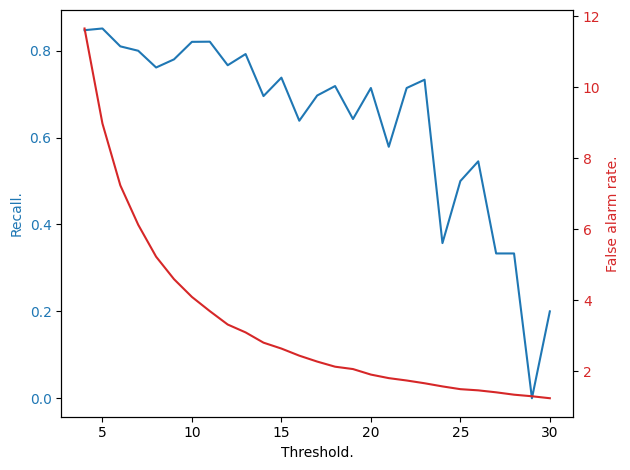

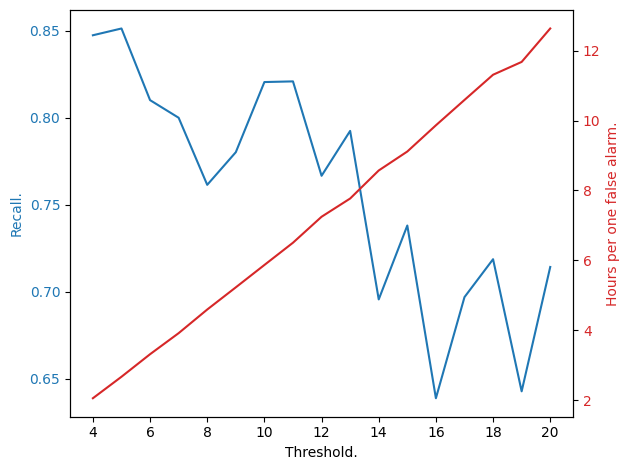

In [9]:
start_threshold = 3
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('False alarm rate.', color=color)
ax2.plot(x[start_threshold:end_threshold], far_list[start_threshold:end_threshold], color=color, label='False alarm rate.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()


start_threshold = 3
end_threshold = 20
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Hours per one false alarm.', color=color)
ax2.plot(x[start_threshold:end_threshold], hpfa_list[start_threshold:end_threshold], color=color, label='Hours per one false alarm.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()

Number of walkings: 173023
Number of falling while walking: 36
Days of falling while walking: {1026, 1410, 389, 3207, 1944, 795, 2331, 1437, 1821, 1055, 673, 2211, 2994, 575, 1216, 1601, 3143, 2121, 1487, 600, 2521, 346, 348, 1628, 1247, 1375, 226, 3047, 2664, 745, 1132, 237, 625, 246, 2166, 2425}


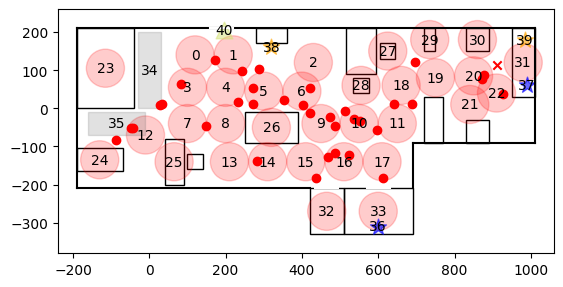

In [16]:
# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.2:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()